<img src="../img/hu-logo.png" align="right" width="120">

# Gradient descent

Let's implement inference for a ___linear model___ using gradient descent.

We will consider the three types of gradient descent we reviewed in the lecture:
1. Batch gradient descent
2. Stochastic gradient descent
3. Mini-batch gradient descent

In [1]:
import tqdm                  # progress bar for loops
import celluloid             # for building animated graphs

import numpy as np
import pandas as pd

import sklearn.linear_model  # our reference solution

import matplotlib.gridspec
import matplotlib.animation
import matplotlib.pyplot as plt

plt.style.use("seaborn-white")

plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "axes.grid": True,
    "axes.axisbelow": True,
    "pcolor.shading": "auto",
})

## Class for training linear regression with (batch) gradient descent

### Mathematical background

#### Formal representation of the problem

Let's look at a linear model

$
\quad y_i = w\, x_i + b
$

that represents our hypothesis $h$.

Here, 

- $y_i$ is the dependent variable,
- $x_i$ the feature vector, and
- $b$ (intercept) and $w$ (slope) are the coefficients (or weights).

We want to find coefficients $b$ and $w$ that make $h(x_i)$ similar to $y_i$ (for the training samples in $\mathcal{X}$). This guides our chocice for the cost function $J$. 

#### Cost function

With
- the prediction $\hat y_i$ and
- the prediction error $e_i$

it follows

$
\quad J(b,w) \\
\quad\quad = \displaystyle \frac 1 n \sum_{i=1}^{n} e_i^2 \\
\quad\quad = \displaystyle \frac 1 n \sum_{i=1}^{n} (y_i - \hat y_i)^2 \\
\quad\quad = \displaystyle \frac 1 n \sum_{i=1}^{n} (y_i - (w\, x_i + b))^2
$

#### Update equations

Gradient descent starts with an initial guess for $b$ and $w$ and then iterates to minimize $J$. With the learning rate $\eta$, we have the following weight upgrade equations

$
\quad\displaystyle w' = w - \eta\,\partial_w J(b,\,w)
$

and

$
\quad\displaystyle b' = b - \eta\, \partial_b J(b,\,w)
$

where $\partial_w J(b,\,w)$ and $\partial_b J(b,\,w)$ are the partial derivates of the cost function with regard our parameters $w$ and $b$.

The partial derivatives of $J$ are

$
\quad \nabla J(b,\,w) \\
\quad\quad = \begin{bmatrix} \partial_b J(b,w) \\ \partial_w J(b,w) \end{bmatrix} \\
\quad\quad = \begin{bmatrix} 
        \displaystyle\frac 2 n \sum_{i=1}^{n} -    (y_i - (w\, x_i + b)) \\
        \displaystyle\frac 2 n \sum_{i=1}^{n} -x_i (y_i - (w\, x_i + b))
\end{bmatrix} 
$

Some notes:
- Gradient descent repeatedly takes a step in the direction of steepest decrease of $J$ (as the name suggests).
- The magnitude of the update is proportional to the error term.

#### Example visualization

<img src="../img/variance-explained.gif" width="500">

[(Source)](https://mlfromscratch.com/linear-regression-from-scratch/)

### Implementation

In [2]:
class LinearRegression(object):

    def __init__(self, w=1, b=1, lr=0.01):
        self.lr = lr
        self.w = np.array([[w]])
        self.b = np.array([b])
        
        self.w_epoch = np.empty(shape=(0))
        self.b_epoch = np.empty(shape=(0))
        self.c_epoch = np.empty(shape=(0))
        self.ys_epoch = np.empty(shape=(2,0))
        
        self.epoch_counter = 0

    def cost(self, x, y):     
        pred = x@self.w + self.b
        e = y - pred
        return np.mean(e**2)

    def step(self, x, y):
        pred = x@self.w+self.b
        e = y-pred

        # partial derivate of J with respect to w
        dJ_dw = np.mean(e*(-2*x), axis=0)

        # partial derivate of J with respect to b
        dJ_db = np.mean(e*(-2), axis=0)

        # update w and b
        self.w = (self.w.T - self.lr*dJ_dw).T
        self.b = self.b - self.lr * dJ_db

    def train(self, x, y, xs, n_epochs=50_000):

        w_epoch = np.zeros(n_epochs)
        b_epoch = np.zeros(n_epochs)
        c_epoch = np.zeros(n_epochs)
        ys_epoch = np.zeros((2, n_epochs))

        for i in tqdm.tqdm(range(n_epochs)):
            w_epoch[i], b_epoch[i] = self.params()
            c_epoch[i] = self.cost(x, y)
            ys_epoch[:, i] = self.predict(xs).T
            self.step(x, y)

        self.w_epoch = np.hstack([self.w_epoch, w_epoch])
        self.b_epoch = np.hstack([self.b_epoch, b_epoch])
        self.c_epoch = np.hstack([self.c_epoch, c_epoch])
        self.ys_epoch = np.hstack([self.ys_epoch, ys_epoch])

        self.epoch_counter += n_epochs

    def predict(self, x):
        return (x @ self.w.T + self.b)

    def params(self):
        return (self.w, self.b)


## Generate data

Our data generating process is a linear model

$
\quad y_i = w\, x_i + b + \epsilon
$

We'll use

- $b^{true} = 3$
- $w^{true} = -3$
- $\varepsilon \sim \mathcal{N}(\mu_{\varepsilon}, \sigma_{\varepsilon})$ with $\mu_{\varepsilon}=0$ and $\sigma_{\varepsilon}=1$


In [3]:
np.random.seed(501)

In [4]:
N = 100

b_true = 3
w_true = -3
sigma_err = 1

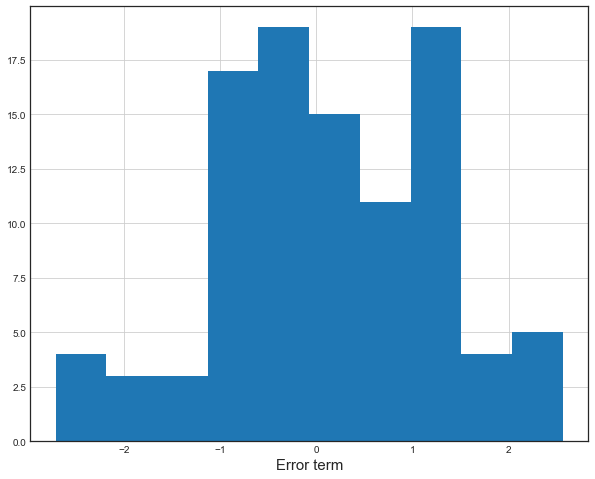

In [5]:
# error term
err = np.random.normal(0, sigma_err, N)
plt.hist(err)
_ = plt.xlabel("Error term")

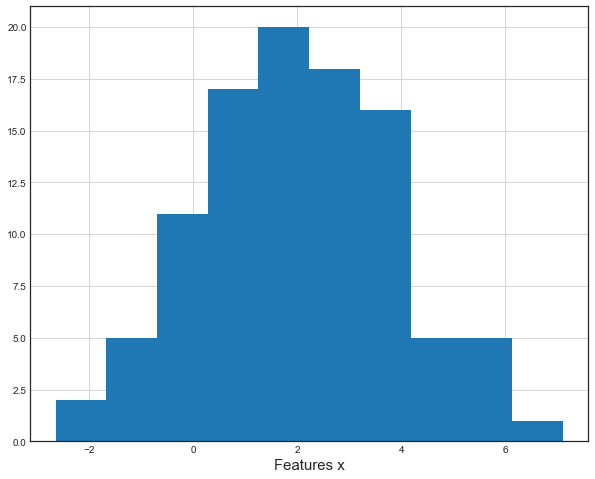

In [6]:
# features
x = np.random.normal(2, 2, N)
_ = plt.hist(x)
_ = plt.xlabel("Features x")

In [7]:
# dependent variable
y = w_true * x + b_true + err

In [8]:
x_train = np.array(x).reshape(-1,1)
y_train = np.array(y).reshape(-1,1)
xs = np.array([[x_train.min()], [x_train.max()]])

## Reference solution: `sklearn`

Let's check whether the true parameters can be inferred from the data.

In [9]:
res_sklearn = sklearn.linear_model.LinearRegression().fit(x_train, y_train)
print(f"b_hat = {res_sklearn.intercept_[0]:.2f}")
print(f"w_hat = {res_sklearn.coef_[0][0]:.2f}")

b_hat = 3.09
w_hat = -2.98


## Batch gradient descent

Now we'll use our own BGD implementation

### Training

In [10]:
# initialize
bgd_model = LinearRegression(
    w=-1,
    b=1,
    lr=0.001
)

bgd_model.train(
    x_train,
    y_train,
    xs=xs,
    n_epochs=10_000
)

100%|██████████| 10000/10000 [00:00<00:00, 19016.47it/s]


In [11]:
print(f"BGD weight: {bgd_model.params()[0][0][0]:.4f}")
print(f"BGD y-intercept: {bgd_model.params()[1][0]:.4f}")
print(f"BGD costs: {bgd_model.cost(x_train, y_train):.4f}")

BGD weight: -2.9840
BGD y-intercept: 3.0894
BGD costs: 1.2793


### Evaluation

In [12]:
# Define which epochs/data points to plot
p = np.hstack([
    np.arange(0, 50, 1),
    np.arange(50, 200, 5),
    np.arange(200, 500, 20),
    np.arange(500, 1_000, 50),
    np.arange(1_000, 3_000, 100),
    np.arange(3_000, 10_000, 500),
    np.arange(10_000, bgd_model.epoch_counter, 1_000)
])

fig = plt.figure(figsize=(20, 10))
font_size_label = 14
font_size_title = 17

gs = matplotlib.gridspec.GridSpec(2, 3, figure=fig)
ax0=fig.add_subplot(gs[:, 0])
ax1=fig.add_subplot(gs[:, 1])
ax2=fig.add_subplot(gs[0, 2], sharex=ax1)
ax3=fig.add_subplot(gs[1, 2], sharex=ax1)

ax0.set_title("Regression", fontsize=font_size_title)
ax0.tick_params(axis="both", which="major", labelsize=font_size_label)
ax0.set_xlabel("x", fontsize=font_size_label)
ax0.set_ylabel("y", fontsize=font_size_label)
ax0.tick_params(axis="both", which="major", labelsize=font_size_label)

ax1.set_title("Cost", fontsize=font_size_title)
ax1.tick_params(axis="both", which="major", labelsize=font_size_label)
ax1.set_xlabel("Epochs", fontsize=font_size_label)
ax1.set_yscale('log')

ax2.set_title("Offset b", fontsize=font_size_title)
ax2.tick_params(axis="both", which="major", labelsize=font_size_label)

ax3.set_title("Slope w", fontsize=font_size_title)
ax3.tick_params(axis="both", which="major", labelsize=font_size_label)
ax3.set_xlabel("Epochs", fontsize=font_size_label)

camera = celluloid.Camera(fig)
for i in p:

    ax1.plot(bgd_model.c_epoch[0:i], color='blue', linestyle="dashed", alpha=0.5)
    ax2.plot(bgd_model.b_epoch[0:i], color='red', linestyle="dashed", alpha=0.5)
    ax3.plot(bgd_model.w_epoch[0:i], color='black',linestyle="dashed")
    
    ax0.scatter(x_train, y_train, color="b", marker="x", s=44)
    leg=ax0.plot(
        xs.T.flatten(),
        bgd_model.ys_epoch[:,i].flatten(),
        color="r",
        label=str(i)
    )
    ax0.legend(leg, [f"epochs: {i}"], loc="upper right", fontsize=font_size_label)

    plt.tight_layout()
    camera.snap()
    plt.close()

anim_lr_1d = camera.animate(
    interval=5,
    repeat=False,
    repeat_delay=500
)

anim_lr_1d.save(
    "../img/gd-overview.gif",
    writer="pillow",
    dpi=100
)

<img src="../img/gd-overview.gif" width="1200">

## Comparison of different gradient descent methods

### Recap lecture

<img src="../img/gradient-descent.png" width="800">

### Extend class

In [13]:
class LinearRegression(object):

    def __init__(self, w=1, b=1, lr=0.01, label="BGD", batch_size=12): 
        self.lr = lr
        self.w = np.array([[w]])
        self.b = np.array([b])
        
        self.w_epoch = np.empty(shape=(0))
        self.b_epoch = np.empty(shape=(0))
        self.c_epoch = np.empty(shape=(0))
        self.ys_epoch = np.empty(shape=(2,0))
        
        self.label = label
        self.idx = np.arange(x_train.shape[0])  ### -- FIX ME -- move to train
        self.batch_size = batch_size

        self.epoch_counter = 0

    def cost(self, x, y):     
        pred = x@self.w + self.b
        e = y - pred
        return np.mean(e**2)

    def step(self, x, y):
        pred = x@self.w+self.b
        e = y-pred

        # partial derivate of J with respect to w
        dJ_dw = np.mean(e*(-2*x), axis=0)

        # partial derivate of J with respect to b
        dJ_db = np.mean(e*(-2), axis=0)

        # update w and b
        self.w = (self.w.T - self.lr*dJ_dw).T
        self.b = self.b - self.lr * dJ_db

    def train(self, x, y, xs, n_epochs=50_000):

        w_epoch = np.zeros(n_epochs)
        b_epoch = np.zeros(n_epochs)
        c_epoch = np.zeros(n_epochs)
        ys_epoch = np.zeros((2, n_epochs))

        if self.label=="MBGD":
            np.random.shuffle(self.idx)  ### -- FIX ME -- move to loop over n_epochs 

        for i in tqdm.tqdm(range(n_epochs)):
            w_epoch[i], b_epoch[i] = self.params()
            c_epoch[i] = self.cost(x, y)
            ys_epoch[:, i] = self.predict(xs).T
            
            if self.label=="BGD":
                # same as before
                self.step(x, y)
                
            elif self.label=="SGD":
                # loop over all samples in training data
                idx_sgd = list(range(x_train.shape[0]))
                np.random.shuffle(idx_sgd)
                for j in idx_sgd:
                    sgd_model.step(x_train[j], y_train[j])
                    
            elif self.label=="MBGD":
                # batch samples, loop over batches
                idx_i = np.split(
                    self.idx[:self.batch_size * (len(self.idx) // self.batch_size)],
                    self.batch_size
                )
                for idx_mb in idx_i:
                    self.step(x_train[idx_mb], y_train[idx_mb])

        self.w_epoch = np.hstack([self.w_epoch, w_epoch])
        self.b_epoch = np.hstack([self.b_epoch, b_epoch])
        self.c_epoch = np.hstack([self.c_epoch, c_epoch])
        self.ys_epoch = np.hstack([self.ys_epoch, ys_epoch])

        self.epoch_counter += n_epochs

    def predict(self, x):
        return (x @ self.w.T + self.b)

    def params(self):
        return (self.w, self.b)


### Batch gradient descent

In [14]:
# initialize
bgd_model = LinearRegression(
    w=-1,
    b=1,
    lr=0.001
)

bgd_model.train(
    x_train,
    y_train,
    xs=xs,
    n_epochs=10_000
)

100%|██████████| 10000/10000 [00:00<00:00, 13595.90it/s]


In [15]:
print(f"BGD weight: {bgd_model.params()[0][0][0]:.4f}")
print(f"BGD y-intercept: {bgd_model.params()[1][0]:.4f}")
print(f"BGD costs: {bgd_model.cost(x_train, y_train):.4f}")

BGD weight: -2.9840
BGD y-intercept: 3.0894
BGD costs: 1.2793


### Stochastic gradient descent

In [16]:
sgd_model = LinearRegression(
    w=-1,
    b=1,
    lr=0.001,
    label="SGD"
)

sgd_model.train(
    x_train,
    y_train,
    xs=xs,
    n_epochs=bgd_model.epoch_counter
)

100%|██████████| 10000/10000 [00:27<00:00, 360.87it/s]


In [17]:
print(f"SGD weight: {sgd_model.params()[0][0][0]:.4f}")
print(f"SGD y-intercept: {sgd_model.params()[1][0]:.4f}")
print(f"SGD costs: {sgd_model.cost(x_train, y_train):.4f}")

SGD weight: -2.9733
SGD y-intercept: 3.0927
SGD costs: 1.2804


### Mini-batch gradient descent

In [18]:
mbgd_model = LinearRegression(
    w=-1,
    b=1,
    lr=0.001,
    label="MBGD",
    batch_size=12
)

mbgd_model.train(
    x_train,
    y_train,
    xs=xs,
    n_epochs=bgd_model.epoch_counter
)

100%|██████████| 10000/10000 [00:05<00:00, 1765.49it/s]


In [19]:
# print parameters and costs after all epochs
print(f"MBGD weight: {mbgd_model.params()[0][0][0]:.4f}")
print(f"MBGD y-intercept: {mbgd_model.params()[1][0]:.4f}")
print(f"MBGD costs: {mbgd_model.cost(x_train, y_train):.4f}")

MBGD weight: -2.9885
MBGD y-intercept: 3.1384
MBGD costs: 1.2810


## Compare results

### Cost function

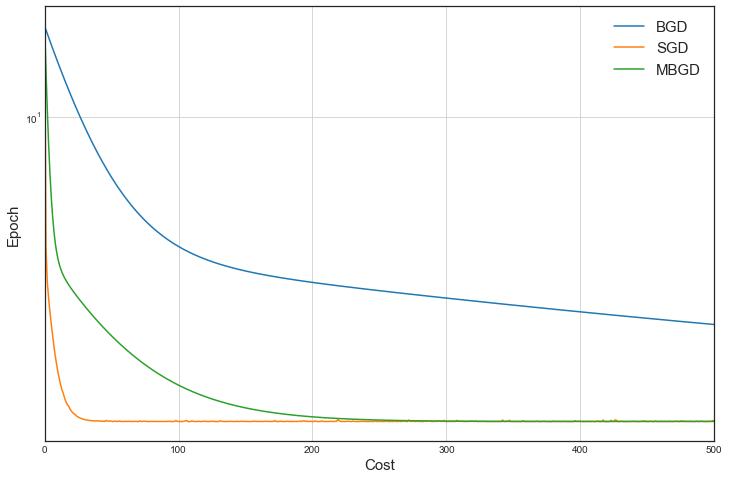

In [20]:
fig = plt.figure(figsize=(12,8))
plt.plot(bgd_model.c_epoch, label="BGD")
plt.plot(sgd_model.c_epoch, label="SGD")
plt.plot(mbgd_model.c_epoch, label="MBGD")
plt.yscale("log")
plt.xlim((0, 500))
plt.xlabel("Cost")
plt.ylabel("Epoch")
_ = plt.legend()

### Cost function and parameters

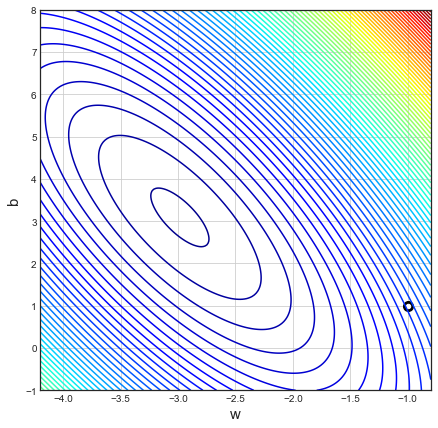

In [21]:
W, B = np.meshgrid(
    np.linspace(-4.2, -0.8, 200),
    np.linspace(-1, 8, 200)
)

def cost_function (x, y, w, b):
    pred = x@w + b
    e = y - pred
    return np.mean(e**2)

zs = np.array([
    cost_function(x_train, y_train, np.array([[w]]), np.array([b]))
    for w, b
    in zip(np.ravel(W), np.ravel(B))
])

Z = zs.reshape(W.shape)

# contour
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.contour(W, B, Z, 100, cmap="jet")
ax1.set_xlabel("w")
ax1.set_ylabel("b")

plt.scatter(-1, 1, c='black', s=100)
_ = plt.scatter(-1, 1, c='white', s=20)

In [22]:
def init_1():
    line1.set_data([], [])
    point1.set_data([], [])
    value_display1.set_text('')
    
    line2.set_data([], [])
    point2.set_data([], [])
    value_display2.set_text('')

    line3.set_data([], [])
    point3.set_data([], [])
    value_display3.set_text('')

    return line1, point1, value_display1, line2, point2, value_display2, line3, point3, value_display3

def animate_1(i):
    p_i = p[i]
    line1.set_data(bgd_model.w_epoch[:p_i], bgd_model.b_epoch[:p_i])
    point1.set_data(bgd_model.w_epoch[p_i], bgd_model.b_epoch[p_i])
    value_display1.set_text(f"Cost(BGD)  = {bgd_model.c_epoch[p_i]:.4f}")
    
    line2.set_data(sgd_model.w_epoch[:p_i], sgd_model.b_epoch[:p_i])
    point2.set_data(sgd_model.w_epoch[p_i], sgd_model.b_epoch[p_i])
    value_display2.set_text(f"Cost(SGD)  = {sgd_model.c_epoch[p_i]:.4f}")

    line3.set_data(mbgd_model.w_epoch[:p_i], mbgd_model.b_epoch[:p_i])
    point3.set_data(mbgd_model.w_epoch[p_i], mbgd_model.b_epoch[p_i])
    value_display3.set_text(f"Cost(MBGD) = {mbgd_model.c_epoch[p_i]:.4f}")

    return line1, point1, value_display1, line2, point2, value_display2, line3, point3, value_display3

In [23]:
linewidth = 2
marker_size = 5
                  
line2, = ax1.plot([], [], "m", label="SGD", linewidth=linewidth)
point2, = ax1.plot([], [], "*", color="m", markersize=marker_size)
value_display2 = ax1.text(0.02, 0.06, "", transform=ax1.transAxes)
value_display2.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

line3, = ax1.plot([], [], "darkorange", label="MBGD", linewidth=linewidth)
point3, = ax1.plot([], [], "*", color="darkorange", markersize=marker_size)
value_display3 = ax1.text(0.02, 0.02, "", transform=ax1.transAxes)
value_display3.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

line1, = ax1.plot([], [], "r", label="BGD", linewidth=linewidth)
point1, = ax1.plot([], [], "*", color="r", markersize=marker_size)
value_display1 = ax1.text(0.02, .10, "", transform=ax1.transAxes)
value_display1.set_bbox(dict(facecolor="white", alpha=0.9, edgecolor="white"))

_ = ax1.legend(loc = 1)

anim1 = matplotlib.animation.FuncAnimation(
    fig1,
    animate_1,
    init_func=init_1,
    frames=len(p),
    interval=100,
    repeat_delay=60,
    blit=True
)

_ = anim1.save(
    "../img/gd-contour.gif",
    writer="pillow",
    dpi=100
)

<img src="../img/gd-contour.gif" width="600">

## Notable extensions and variants of gradient descent

- Gradient descent with momentum
- Averaged gradient descent
- AdaGrad
- RMSProp
- Adam

Check the documentatin of neural network frameworks (e.g., PyTorch, Keras).

&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Lecture 3 <br>
2020 <br>

Based on [Link1](https://towardsdatascience.com/gradient-descent-animation-1-simple-linear-regression-e49315b24672) and [Link2](https://xavierbourretsicotte.github.io/animation_ridge.html)